In [ ]:
!pip install deap

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

# Load ResNet50
from torchvision.models.resnet import resnet50
model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  # Output layer for 10 classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training Function
def train_model(model, train_loader, epochs=10, lr=0.02):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

print("Training the model for feature extraction...")
train_model(model, train_loader, epochs=10, lr=0.001)



In [ ]:
print("Freezing all layers except the last fully connected layer...")
for param in model.parameters():
    param.requires_grad = False

# Reinitialize the weights of the last fully connected layer and enable gradients
nn.init.xavier_uniform_(model.fc.weight)  # Randomize weights
nn.init.zeros_(model.fc.bias)            # Initialize bias to zero
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

Running GA optimization with dynamic mutation rate...
gen	nevals	avg     	std      	min 	max  
0  	150   	0.100013	0.0384907	0.02	0.205
1  	148   	0.124507	0.0401799	0.032	0.258
Generation 1/100, Mutation Rate: 0.9000, Best Fitness: 0.2290
gen	nevals	avg     	std      	min  	max  
0  	0     	0.124507	0.0401799	0.032	0.258
1  	148   	0.157527	0.0427945	0.048	0.31 
Generation 2/100, Mutation Rate: 0.8910, Best Fitness: 0.2910
gen	nevals	avg     	std      	min  	max 
0  	0     	0.157527	0.0427945	0.048	0.31
1  	143   	0.188353	0.0528201	0.054	0.34
Generation 3/100, Mutation Rate: 0.8820, Best Fitness: 0.3380
gen	nevals	avg     	std      	min  	max 
0  	0     	0.188353	0.0528201	0.054	0.34
1  	149   	0.221513	0.0495939	0.12 	0.409
Generation 4/100, Mutation Rate: 0.8730, Best Fitness: 0.3710
gen	nevals	avg     	std      	min 	max  
0  	0     	0.221513	0.0495939	0.12	0.409
1  	146   	0.257427	0.0458162	0.143	0.36 
Generation 5/100, Mutation Rate: 0.8640, Best Fitness: 0.3490
gen	nevals	avg 

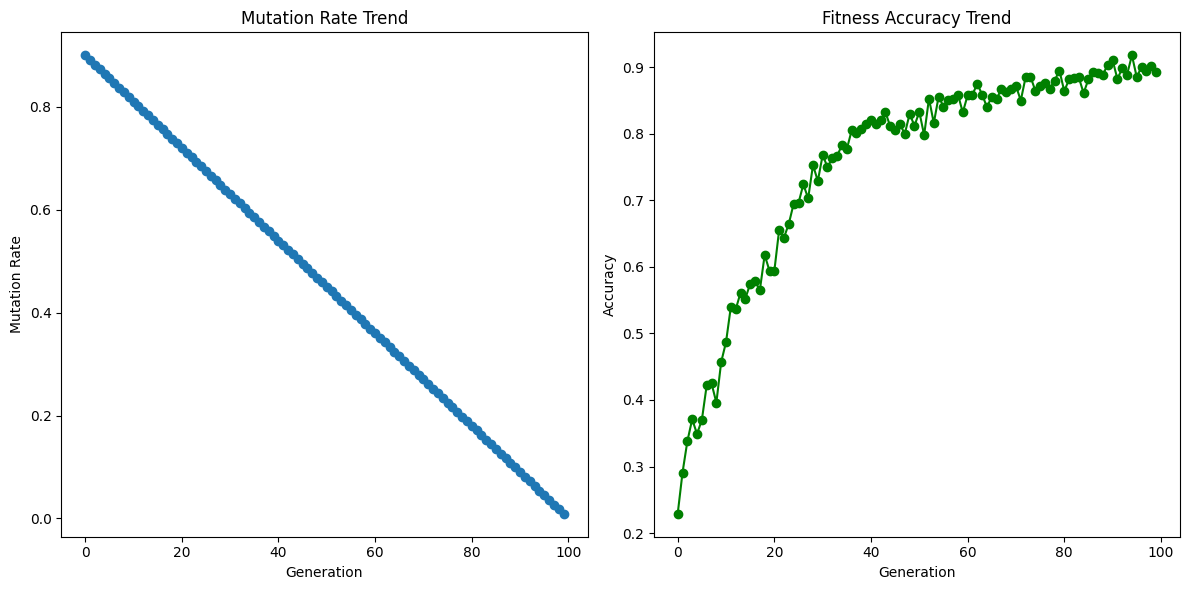

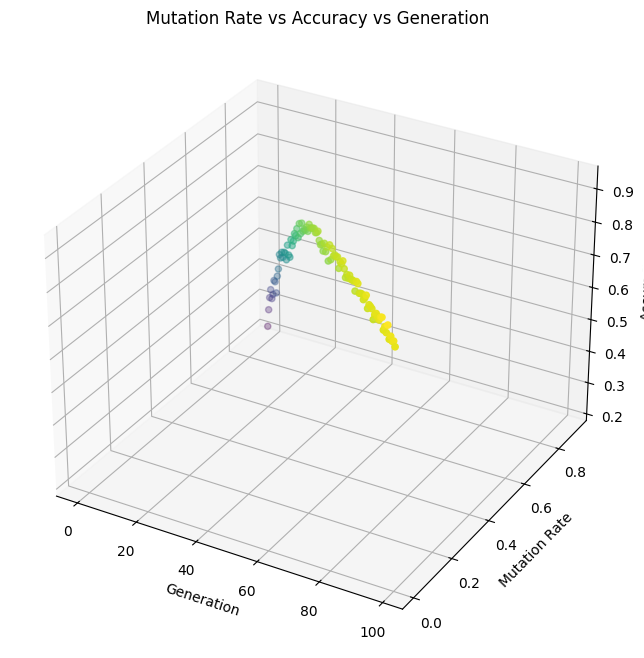

In [ ]:
# Fitness Evaluation for GA
def evaluate_individual(individual, model, data_loader, subset_size=1000):
    with torch.no_grad():
        subset_loader = torch.utils.data.DataLoader(
            dataset=data_loader.dataset,
            batch_size=subset_size,
            shuffle=True
        )
        images, labels = next(iter(subset_loader))
        images, labels = images.to(device), labels.to(device)

        # Convert individual to weights and biases
        num_weights = model.fc.weight.numel()
        weights = np.array(individual[:num_weights]).reshape(model.fc.weight.shape).astype(np.float32)
        biases = np.array(individual[num_weights:]).reshape(model.fc.bias.shape).astype(np.float32)

        model.fc.weight.data = torch.tensor(weights).to(device)
        model.fc.bias.data = torch.tensor(biases).to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        return correct / len(labels),  # Return accuracy as tuple

# Run Genetic Algorithm with Dynamic Mutation Rate
def run_ga_with_deap_dynamic(model, data_loader, params):
    # GA Parameters
    population_size = params.get("population_size", 150)
    generations = params.get("generations", 50)
    crossover_rate = params.get("crossover_rate", 0.8)
    initial_mutation_rate = params.get("mutation_rate", 0.9)
    elitism_count = params.get("elitism_count", 1)

    num_weights = model.fc.weight.numel() + model.fc.bias.numel()

    # DEAP Initialization
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, -1.0, 1.0)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=num_weights)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evaluate_individual, model=model, data_loader=data_loader)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Population and Statistics
    population = toolbox.population(n=population_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    hof = tools.HallOfFame(elitism_count)

    # Dynamic Mutation Rate
    def dynamic_mutation_rate(generation, max_generations):
        return initial_mutation_rate * (1 - generation / max_generations)

    mutation_rates = []
    accuracies = []

    print("Running GA optimization with dynamic mutation rate...")
    for gen in range(generations):
        # Adjust mutation rate dynamically
        current_mutation_rate = dynamic_mutation_rate(gen, generations)
        toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.05, indpb=current_mutation_rate)
        mutation_rates.append(current_mutation_rate)

        # Run a single generation
        population, logbook = algorithms.eaSimple(
            population,
            toolbox,
            cxpb=crossover_rate,
            mutpb=current_mutation_rate,
            ngen=1,
            stats=stats,
            halloffame=hof,
            verbose=True,
        )

        # Evaluate best individual on train_loader
        best_individual = hof[0]
        best_fitness = evaluate_individual(best_individual, model, data_loader)[0]
        accuracies.append(best_fitness)
        print(f"Generation {gen + 1}/{generations}, Mutation Rate: {current_mutation_rate:.4f}, Best Fitness: {best_fitness:.4f}")

    return hof[0], mutation_rates, accuracies

# Run GA with dynamic mutation
ga_params_dynamic = {
    "population_size": 150,
    "generations": 100,  # Adjusted for faster runtime
    "crossover_rate": 0.8,
    "mutation_rate": 0.9,
    "elitism_count": 1
}
best_weights_dynamic, mutation_rates, accuracies = run_ga_with_deap_dynamic(model, train_loader, ga_params_dynamic)

# Apply Best Weights
print("Applying the best weights from dynamic mutation GA...")
with torch.no_grad():
    num_weights = model.fc.weight.numel()
    model.fc.weight.data = torch.tensor(best_weights_dynamic[:num_weights]).reshape(model.fc.weight.shape).to(device).float()
    model.fc.bias.data = torch.tensor(best_weights_dynamic[num_weights:]).reshape(model.fc.bias.shape).to(device).float()

# Final Evaluation
def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    print(f"Final Accuracy: {100 * correct / total:.2f}%")

print("Evaluating the final model with dynamic mutation rate...")
evaluate_model(model, test_loader)

# Plot 2D and 3D Results
plt.figure(figsize=(12, 6))

# Plot Mutation Rate Trend
plt.subplot(1, 2, 1)
plt.plot(range(len(mutation_rates)), mutation_rates, marker='o')
plt.title('Mutation Rate Trend')
plt.xlabel('Generation')
plt.ylabel('Mutation Rate')

# Plot Accuracy Trend
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracies)), accuracies, marker='o', color='green')
plt.title('Fitness Accuracy Trend')
plt.xlabel('Generation')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# 3D Plot for Mutation Rate, Accuracy, and Generation
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
generations = list(range(len(accuracies)))

ax.scatter(generations, mutation_rates, accuracies, c=accuracies, cmap='viridis')
ax.set_title("Mutation Rate vs Accuracy vs Generation")
ax.set_xlabel("Generation")
ax.set_ylabel("Mutation Rate")
ax.set_zlabel("Accuracy")

plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming `mutation_rates` and `accuracies` are available from the GA process
# `mutation_rates`: List of mutation rates per generation
# `accuracies`: List of corresponding accuracies per generation

# Plot Accuracy vs Mutation Rate
plt.figure(figsize=(10, 6))
plt.scatter(mutation_rates, accuracies, c='blue', alpha=0.6, edgecolors='k')
plt.title("Relationship Between Accuracy and Mutation Rate", fontsize=14)
plt.xlabel("Mutation Rate", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True)
plt.show()

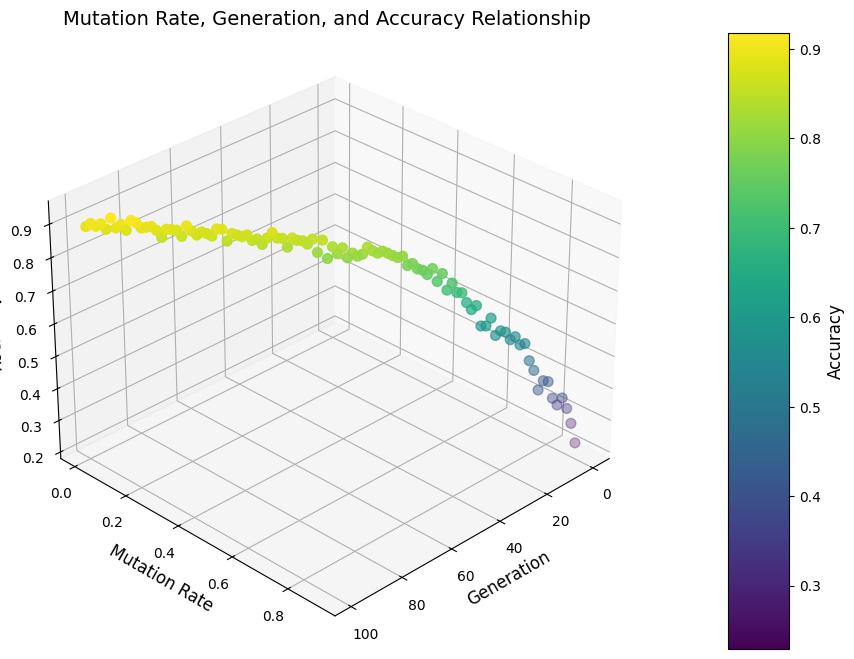

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming `mutation_rates`, `accuracies`, and `generations` are available
# `mutation_rates`: List of mutation rates per generation
# `accuracies`: List of corresponding accuracies per generation
# `generations`: List of generations (e.g., 0, 1, 2, ..., len(accuracies)-1)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
sc = ax.scatter(generations, mutation_rates, accuracies, c=accuracies, cmap='viridis', s=50)

# Adding color bar
color_bar = plt.colorbar(sc, pad=0.1, aspect=10)
color_bar.set_label('Accuracy', fontsize=12)

# Labels and title
ax.set_title("Mutation Rate, Generation, and Accuracy Relationship", fontsize=14)
ax.set_xlabel("Generation", fontsize=12)
ax.set_ylabel("Mutation Rate", fontsize=12)
ax.set_zlabel("Accuracy", fontsize=12)

# Rotate the plot for different views
ax.view_init(elev=30, azim=45)  # Adjust elevation and azimuthal angle

plt.show()


In [ ]:
torch.save(model, "resnet50.pth")